In [1]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True, 
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(
                                          trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2
)

Files already downloaded and verified


In [27]:
def imshow(img):
  # img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [28]:
class Encoder(nn.Module):
  def __init__(self, hidden_dim, latent_dim):
    super(Encoder, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, 5, padding=(2, 2))
    self.conv2 = nn.Conv2d(16, 32, 5, padding=(2, 2))
    self.conv3 = nn.Conv2d(32, 64, 5, padding=(2, 2))

    self.fc1 = nn.Linear(64 * 4 * 4, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    self.mean = nn.Linear(hidden_dim, latent_dim)
    self.var = nn.Linear(hidden_dim, latent_dim)

    self.pool = nn.MaxPool2d(2, 2)
    self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = self.pool(self.leaky_relu(self.conv1(x)))
    x = self.pool(self.leaky_relu(self.conv2(x)))
    x = self.pool(self.leaky_relu(self.conv3(x)))

    x = torch.flatten(x, 1)
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))

    mean = self.mean(x)
    var = self.var(x)

    return mean, var

In [29]:
class Decoder(nn.Module):
  def __init__(self, hidden_dim, latent_dim):
    super(Decoder, self).__init__()
    
    self.fc1 = nn.Linear(latent_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 64 * 4 * 4)

    self.convt1 = nn.ConvTranspose2d(64, 32, 5, padding=(2, 2))
    self.convt2 = nn.ConvTranspose2d(32, 16, 5, padding=(2, 2))
    self.convt3 = nn.ConvTranspose2d(16, 3, 5, padding=(2, 2))

    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))

    x = torch.reshape(x, (-1, 64, 4, 4))

    x = self.upsample(self.leaky_relu(self.convt1(x)))
    x = self.upsample(self.leaky_relu(self.convt2(x)))
    x = self.upsample(self.leaky_relu(self.convt3(x)))
    x = torch.sigmoid(x)

    return x

In [30]:
class VAE(nn.Module):
  def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
  def reparameterization(self, mean, var):
      epsilon = torch.randn_like(var).to(device)    
      z = mean + var * epsilon                         
      return z
                
  def forward(self, x):
      mean, log_var = self.encoder(x)
      z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
      x_hat = self.decoder(z)
      
      return x_hat, mean, log_var

In [31]:
latent_dim = 100
hidden_dim = 200

In [32]:
encoder = Encoder(hidden_dim, latent_dim)
decoder = Decoder(hidden_dim, latent_dim)

vae = VAE(encoder, decoder).to(device)

In [33]:
bce_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
  reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
  # print(reproduction_loss.item(), KLD.item())
  return reproduction_loss + KLD

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [34]:
epochs = 100

for epoch in range(1, epochs + 1):
  total_loss = 0.0

  for batch, data in enumerate(trainloader):
    images, _ = data
    images = images.to(device)

    optimizer.zero_grad()
    x_hat, mean, log_var = vae(images)
    loss = loss_function(images, x_hat, mean, log_var)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f'[{epoch}/{epochs}] loss: {total_loss}')

[1/100] loss: 100464287.09375
[2/100] loss: 97096072.375
[3/100] loss: 96269878.140625
[4/100] loss: 95369318.4375
[5/100] loss: 94626066.625
[6/100] loss: 94097096.15625
[7/100] loss: 93916995.96875
[8/100] loss: 93764658.515625
[9/100] loss: 93565525.875
[10/100] loss: 93480190.90625
[11/100] loss: 93326050.203125
[12/100] loss: 93171968.078125
[13/100] loss: 93054301.78125
[14/100] loss: 93004273.078125
[15/100] loss: 92913750.859375
[16/100] loss: 92863462.8125
[17/100] loss: 92849095.890625
[18/100] loss: 92818282.84375
[19/100] loss: 92802520.828125
[20/100] loss: 92738590.34375
[21/100] loss: 92702160.78125
[22/100] loss: 92658668.546875
[23/100] loss: 92620780.15625
[24/100] loss: 92565005.796875
[25/100] loss: 92512827.703125
[26/100] loss: 92480556.140625
[27/100] loss: 92453069.640625
[28/100] loss: 92428774.171875
[29/100] loss: 92391889.078125
[30/100] loss: 92356600.296875
[31/100] loss: 92341210.515625
[32/100] loss: 92308167.828125
[33/100] loss: 92265571.4375
[34/100] 

In [35]:
with torch.no_grad():
    noise = torch.randn(8, latent_dim).to(device)
    generated_images = decoder(noise).cpu()

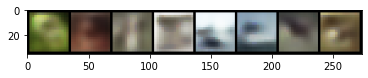

In [36]:
imshow(torchvision.utils.make_grid(generated_images))